<h2 style="color: blue" align="center">Spaceship Titanic <h2/>

## Data Overview

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
<br>
**PassengerId**- A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
<br>
**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
<br>
**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
<br>
**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
<br>
**Destination** - The planet the passenger will be debarking to.
<br>
**Age** - The age of the passenger.
<br>
**VIP** - Whether the passenger has paid for special VIP service during the voyage.
<br>
**RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
<br>
**Name** - The first and last names of the passenger.
<br>
**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
<br>
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [125]:
df_raw = pd.read_csv("data\\train.csv")
print("Shape before split: ",df_raw.shape)
df_raw.head()


Shape before split:  (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [126]:
X = df_raw.drop("Transported", axis=1)
y = df_raw["Transported"]

X_train, X_val, y_train, y_val= train_test_split(X,y,random_state=1337, test_size=0.2)

print("Train shape: ", X_train.shape)
print("Val shape: ", X_val.shape)

Train shape:  (6954, 13)
Val shape:  (1739, 13)


In [127]:
df_train = pd.concat((X_train, y_train), axis=1)
df_train.shape

(6954, 14)

## Data Understanding

In [128]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6954 entries, 4049 to 3223
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6787 non-null   object 
 2   CryoSleep     6788 non-null   object 
 3   Cabin         6788 non-null   object 
 4   Destination   6812 non-null   object 
 5   Age           6810 non-null   float64
 6   VIP           6793 non-null   object 
 7   RoomService   6804 non-null   float64
 8   FoodCourt     6804 non-null   float64
 9   ShoppingMall  6798 non-null   float64
 10  Spa           6810 non-null   float64
 11  VRDeck        6813 non-null   float64
 12  Name          6805 non-null   object 
dtypes: float64(6), object(7)
memory usage: 760.6+ KB


In [129]:
X_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6810.000000,6804.000000,6804.000000,6798.000000,6810.000000,6813.000000
mean,28.844347,219.848471,460.488536,172.003678,313.217621,313.176281
std,14.583124,661.642078,1618.347967,612.051347,1146.283318,1150.679361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,39.000000,79.000000,27.000000,64.750000,52.000000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [130]:
X_train.isna().sum()

PassengerId       0
HomePlanet      167
CryoSleep       166
Cabin           166
Destination     142
Age             144
VIP             161
RoomService     150
FoodCourt       150
ShoppingMall    156
Spa             144
VRDeck          141
Name            149
dtype: int64

### I think we can easily assume that neither Name has nothing to do with being transported -> im going to drop both columns right away

In [131]:
X_train = X_train.drop(columns=["Name"]).copy()
X_val =  X_val.drop(columns=["Name"]).copy()

In [132]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
4049,4327_01,Earth,False,F/811/S,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0
7198,7692_01,Europa,False,C/287/S,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0
538,0571_02,Europa,True,C/21/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0
7371,7882_02,Earth,False,G/1271/P,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0
4974,5304_01,Mars,False,F/1019/S,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0


### Handle PassengerID here

In [133]:
def get_prefix(row):
    return row[:4]

X_train["Prefix"] = X_train["PassengerId"].apply(get_prefix)

X_train["Grouped"] = X_train["Prefix"].duplicated(keep=False)

In [134]:
X_train = X_train.drop(columns=["PassengerId", "Prefix"]).copy()

In [135]:
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped
4049,Earth,False,F/811/S,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False
7198,Europa,False,C/287/S,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0,False
538,Europa,True,C/21/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True
7371,Earth,False,G/1271/P,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,True
4974,Mars,False,F/1019/S,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0,True


### Correctly Handle Cabin here 

In [ ]:
#Assumption:
#Firstly -> first sign of Cabin is either The cabin number where the passenger is staying. Takes the form deck/num/side, AND LAST IS where side can be either P for Port or S for Starboard.
#Number doesnt matter. but the first and the last sign does. Lets make 2 columns out of that.

In [136]:
def dummy(row):
    litera = str(row)[:1]
    return litera
X_train["Deck"] = X_train["Cabin"].apply(dummy)

In [137]:
X_train.head(1)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped,Deck
4049,Earth,False,F/811/S,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False,F


In [138]:
def get_cabin(row):
    if str(row).endswith("S"):
        return "Starboard"
    elif str(row).endswith("P"):
        return "Port"
    else:
        return "Unknown"
    
X_train["Cabin"] = X_train["Cabin"].apply(get_cabin)
X_train.head(3)
    

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped,Deck
4049,Earth,False,Starboard,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False,F
7198,Europa,False,Starboard,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0,False,C
538,Europa,True,Port,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True,C


In [139]:
X_train["Cabin_Deck"] = X_train["Deck"] + "-" + X_train["Cabin"]
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped,Deck,Cabin_Deck
4049,Earth,False,Starboard,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False,F,F-Starboard
7198,Europa,False,Starboard,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0,False,C,C-Starboard
538,Europa,True,Port,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True,C,C-Port
7371,Earth,False,Port,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,True,G,G-Port
4974,Mars,False,Starboard,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0,True,F,F-Starboard


In [140]:
X_train = X_train.drop(columns=["Cabin", "Deck"])

In [141]:
X_train.head()

##I shall try training with this dataset, and see how the results are going to be impacted. Also, dropping HomePlanet, Destination and Age is still something to think about.

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped,Cabin_Deck
4049,Earth,False,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False,F-Starboard
7198,Europa,False,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0,False,C-Starboard
538,Europa,True,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True,C-Port
7371,Earth,False,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,True,G-Port
4974,Mars,False,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0,True,F-Starboard


#### Make a total_spent column instead of multiple worthless ones

In [142]:
X_train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Grouped', 'Cabin_Deck'],
      dtype='object')

In [143]:
X_train["Total_Spent"] = X_train["RoomService"] + X_train["FoodCourt"] + X_train["ShoppingMall"] + X_train["Spa"] + X_train["VRDeck"]

In [144]:
X_train = X_train.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"])


In [145]:
X_train.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,Grouped,Cabin_Deck,Total_Spent
4049,Earth,False,TRAPPIST-1e,20.0,False,False,F-Starboard,899.0


In [146]:
categorical_columns = ["HomePlanet", "CryoSleep", "Cabin_Deck","Destination", "VIP"]
numeric_columns = ["Age", "Total_Spent"]

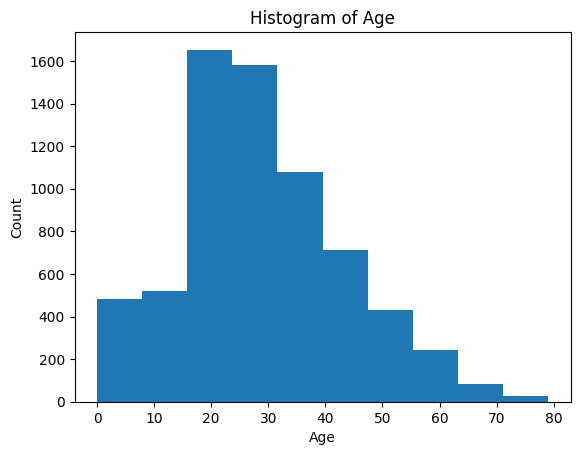

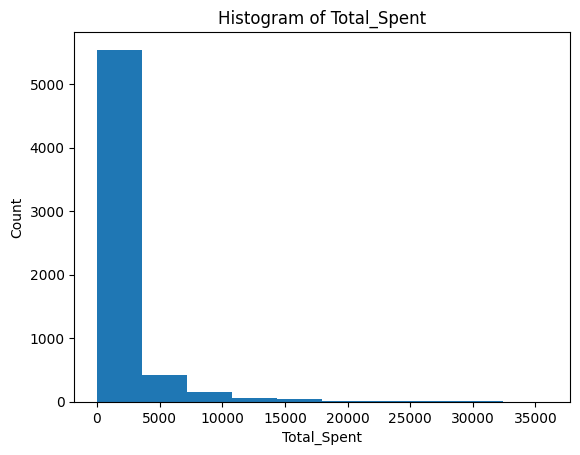

In [147]:
for col in numeric_columns:
    X_train[col].plot(kind="hist")
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()
    


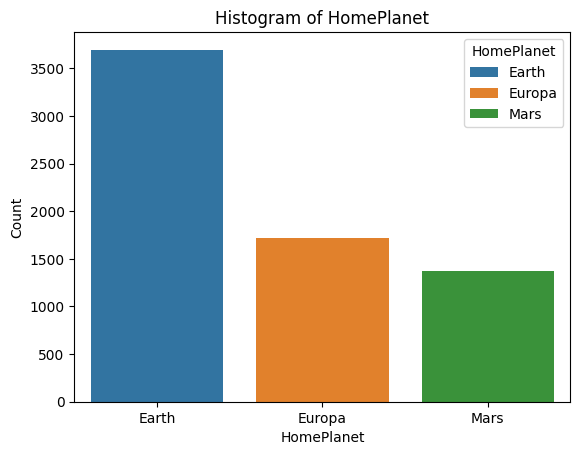

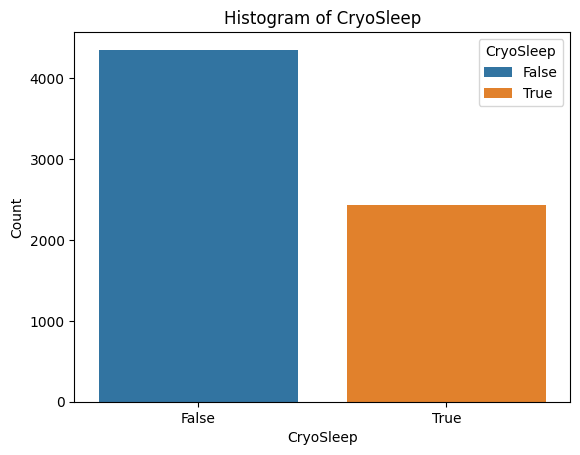

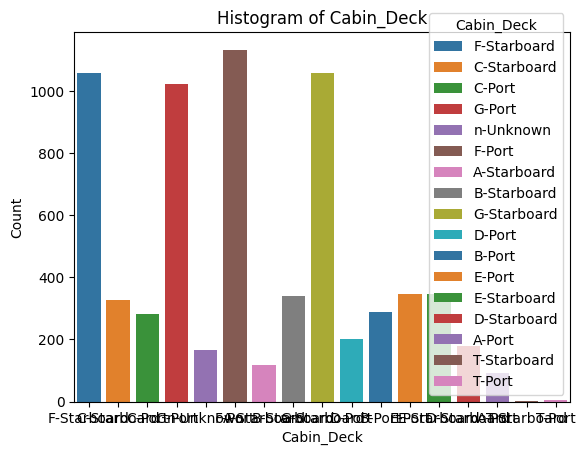

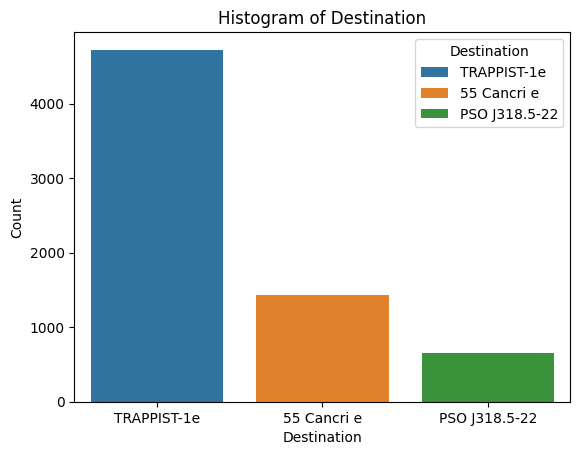

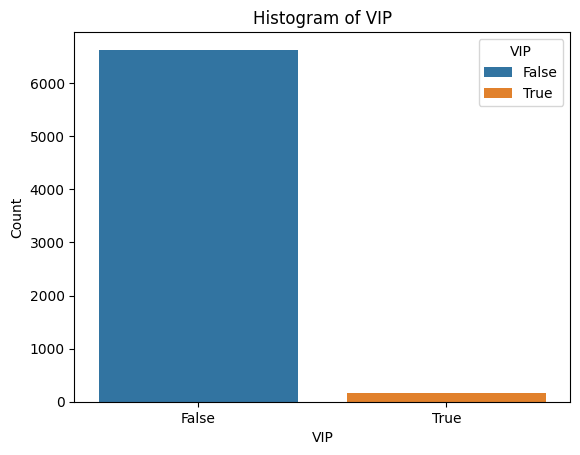

In [34]:
for col in categorical_columns:
    sns.countplot(data=X_train, x=col, palette='tab10', hue=col, legend=True)
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()
    

#### Day 1 done - early exploration and data understanding. eta time spent: 45min

### Data Cleaning

In [148]:
df_train = pd.concat((X_train, y_train), axis=1)
df_train.shape

(6954, 9)

In [149]:
df_train[categorical_columns].isna().sum()

HomePlanet     167
CryoSleep      166
Cabin_Deck       0
Destination    142
VIP            161
dtype: int64

In [150]:
pct_vip_transported = df_train[df_train["VIP"] == True]["Transported"].sum() / df_train[df_train["VIP"] == True].shape[0]
pct_vip_transported

0.391304347826087

In [151]:
pct_nonvip_transported = df_train[df_train["VIP"] == False]["Transported"].sum() / df_train[df_train["VIP"] == False].shape[0]
pct_nonvip_transported

0.502714113389626

<Axes: xlabel='HomePlanet'>

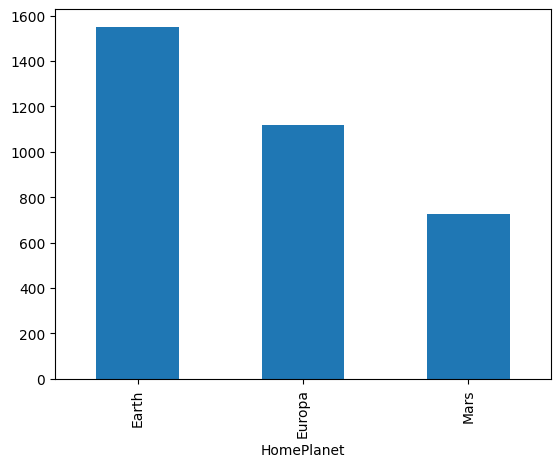

In [152]:
df_train.groupby("HomePlanet")["Transported"].sum().plot(kind='bar')

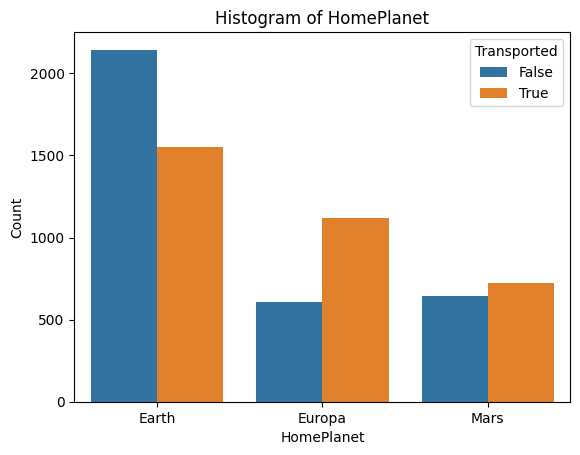

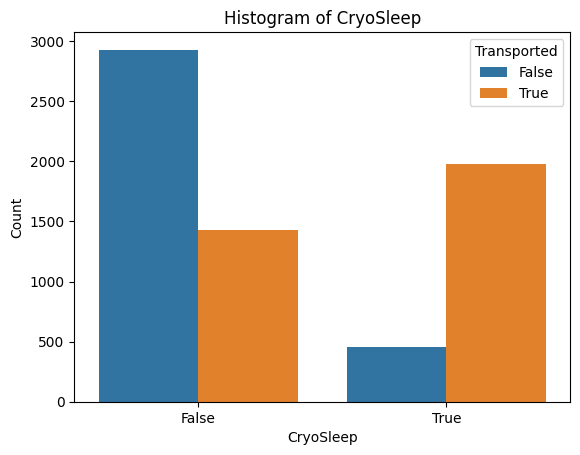

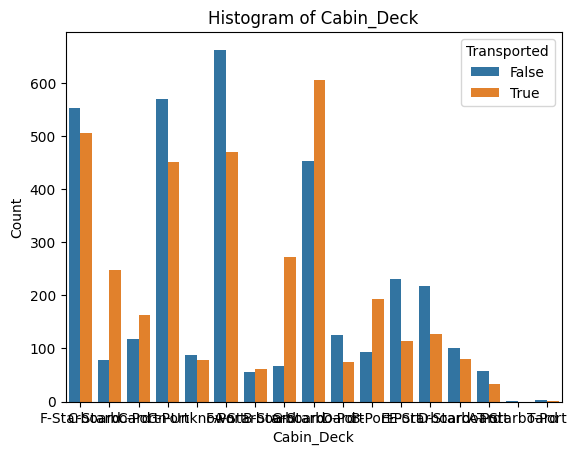

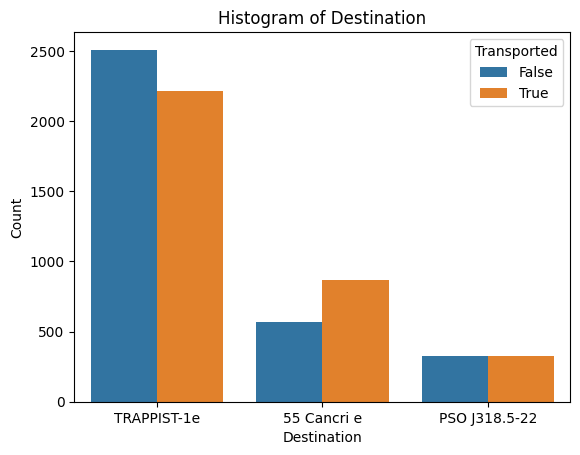

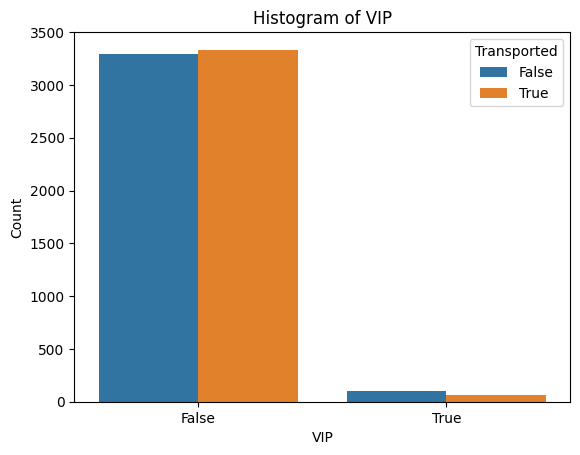

In [153]:
for col in categorical_columns:
    sns.countplot(data=df_train, x=col, palette='tab10', hue="Transported", legend=True)
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()

## NA values handling

#### Based on plots:
1. We can safely add "False" as default data to **VIP** column, as there is no significant difference.



In [154]:
df_train[categorical_columns].isna().sum()

HomePlanet     167
CryoSleep      166
Cabin_Deck       0
Destination    142
VIP            161
dtype: int64

In [155]:
df_train["VIP"] = df_train["VIP"].fillna("False")
df_train["VIP"].isna().sum()


0

## To future self:
If i had enough time to handle this, the best approach would be: count the median for people of NA, eg. 'HomePlanet', see other important columns like 'CryoSleep', "Destination" and "Transported" - and based on this evaluate and fill those missing values. But since this is a training task and the model is no going to production (well at least I hope there wont be any space titanic disasters in the near future) I shall go with the easiest approach -> fill up all the missing values with mode. I wont be deleting them, because there is little data.

In [156]:
mode_planet = df_train["HomePlanet"].mode()[0]
mode_cryo = df_train["CryoSleep"].mode()[0]
mode_destination = df_train["Destination"].mode()[0]

mode_planet

'Earth'

In [157]:
df_train["HomePlanet"] = df_train["HomePlanet"].fillna(mode_planet)
df_train["CryoSleep"] = df_train["CryoSleep"].fillna(mode_cryo)
df_train["Destination"] = df_train["Destination"].fillna(mode_destination)


C:\Users\USER\AppData\Local\Temp\ipykernel_11540\2601116422.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train["CryoSleep"] = df_train["CryoSleep"].fillna(mode_cryo)


In [158]:
df_train[categorical_columns].isna().sum()

HomePlanet     0
CryoSleep      0
Cabin_Deck     0
Destination    0
VIP            0
dtype: int64

In [159]:
df_train.isna().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age            144
VIP              0
Grouped          0
Cabin_Deck       0
Total_Spent    717
Transported      0
dtype: int64

### Based on the plots -> most frequent value in spendings was 0 -> that's why im using it to fill NA in numeric columns

In [160]:
df_train["Total_Spent"] = df_train["Total_Spent"].fillna(0)


In [161]:
df_train.isna().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age            144
VIP              0
Grouped          0
Cabin_Deck       0
Total_Spent      0
Transported      0
dtype: int64

In [174]:
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].median())
df_train.isna().sum()

HomePlanet     0
CryoSleep      0
Destination    0
Age            0
VIP            0
Grouped        0
Cabin_Deck     0
Total_Spent    0
Transported    0
dtype: int64

#Applying all the logic from before to X_val

In [162]:
X_val.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
1729,1843_01,Europa,False,E/112/P,TRAPPIST-1e,46.0,False,2249.0,153.0,137.0,NaN,194.0


In [163]:
X_val["Prefix"] = X_val["PassengerId"].apply(get_prefix)
X_val["Grouped"] = X_val["Prefix"].duplicated(keep=False)
X_val = X_val.drop(columns=["PassengerId", "Prefix"]).copy()

In [164]:
X_val["Deck"] = X_val["Cabin"].apply(dummy)
X_val["Cabin"] = X_val["Cabin"].apply(get_cabin)


In [165]:
X_val["Cabin_Deck"] = X_val["Deck"] + "-" + X_val["Cabin"]
X_val = X_val.drop(columns=["Cabin", "Deck"])

In [166]:
X_val["Total_Spent"] = X_val["RoomService"] + X_val["FoodCourt"] + X_val["ShoppingMall"] + X_val["Spa"] + X_val["VRDeck"]

X_val = X_val.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"])

In [167]:
## NA VALUES based on train

X_val["VIP"] = X_val["VIP"].fillna("False")

In [168]:
X_val["HomePlanet"] = X_val["HomePlanet"].fillna(mode_planet)
X_val["CryoSleep"] = X_val["CryoSleep"].fillna(mode_cryo)
X_val["Destination"] = X_val["Destination"].fillna(mode_destination)

C:\Users\USER\AppData\Local\Temp\ipykernel_11540\1601733807.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_val["CryoSleep"] = X_val["CryoSleep"].fillna(mode_cryo)


In [169]:
X_val["Total_Spent"] = X_val["Total_Spent"].fillna(0)

In [170]:
X_val["Age"] =X_val["Age"].fillna(df_train["Age"].median())

In [171]:
X_train.shape, X_val.shape, df_train.shape

((6954, 8), (1739, 8), (6954, 9))

### Encoding and Preparing for Training

In [176]:
X_train = df_train.drop("Transported", axis=1)
y_train = df_train["Transported"]

##for safety purposes

In [179]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

In [180]:
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])

In [181]:
X_train.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,Grouped,Cabin_Deck,Total_Spent
4049,Earth,False,TRAPPIST-1e,-0.610154,False,False,F-Starboard,-0.161293


In [182]:
X_val.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,Grouped,Cabin_Deck,Total_Spent
1729,Europa,False,TRAPPIST-1e,1.191314,False,False,E-Port,-0.48914


In [183]:
X_train["VIP"] = X_train["VIP"].map({True: 1, False: 0})
X_val["VIP"] = X_val["VIP"].map({True:1, False:0})

In [184]:
X_train.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,Grouped,Cabin_Deck,Total_Spent
4049,Earth,False,TRAPPIST-1e,-0.610154,0.0,False,F-Starboard,-0.161293


#### Note: Maybe cabin_deck isnt ideal for now - shall be tested in the future. Will see how the model will perform. Probably can drop either starboard/port shape, or the Deck shape. 

In [185]:
from sklearn.preprocessing import OneHotEncoder
cols_to_encode = ["HomePlanet", "Destination", "Cabin_Deck"]
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(X_train[cols_to_encode])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [186]:


X_ohe_train = pd.DataFrame(ohe.transform(X_train[cols_to_encode]),
                           columns=ohe.get_feature_names_out(cols_to_encode),
                           index=X_train.index)

X_train_full = pd.concat([X_train.drop(columns=cols_to_encode), X_ohe_train], axis=1)

In [187]:

cols_to_scale = ["HomePlanet", "Destination", "Cabin_Deck"]
X_ohe_val = pd.DataFrame(ohe.transform(X_val[cols_to_encode]),
                           columns=ohe.get_feature_names_out(cols_to_encode),
                           index=X_val.index)

X_val_full = pd.concat([X_val.drop(columns=cols_to_encode), X_ohe_val], axis=1)

### Model Training

In [188]:
y_train.value_counts() #no imbalance within classes

Transported
True     3479
False    3475
Name: count, dtype: int64

In [193]:
X_train_full["VIP"] = X_train_full["VIP"].fillna(0)
X_train_full.isna().sum()

CryoSleep                    0
Age                          0
VIP                          0
Grouped                      0
Total_Spent                  0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Cabin_Deck_A-Port            0
Cabin_Deck_A-Starboard       0
Cabin_Deck_B-Port            0
Cabin_Deck_B-Starboard       0
Cabin_Deck_C-Port            0
Cabin_Deck_C-Starboard       0
Cabin_Deck_D-Port            0
Cabin_Deck_D-Starboard       0
Cabin_Deck_E-Port            0
Cabin_Deck_E-Starboard       0
Cabin_Deck_F-Port            0
Cabin_Deck_F-Starboard       0
Cabin_Deck_G-Port            0
Cabin_Deck_G-Starboard       0
Cabin_Deck_T-Port            0
Cabin_Deck_T-Starboard       0
Cabin_Deck_n-Unknown         0
dtype: int64

In [194]:
X_val_full["VIP"] = X_val_full["VIP"].fillna(0)
X_val_full.isna().sum()

CryoSleep                    0
Age                          0
VIP                          0
Grouped                      0
Total_Spent                  0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Cabin_Deck_A-Port            0
Cabin_Deck_A-Starboard       0
Cabin_Deck_B-Port            0
Cabin_Deck_B-Starboard       0
Cabin_Deck_C-Port            0
Cabin_Deck_C-Starboard       0
Cabin_Deck_D-Port            0
Cabin_Deck_D-Starboard       0
Cabin_Deck_E-Port            0
Cabin_Deck_E-Starboard       0
Cabin_Deck_F-Port            0
Cabin_Deck_F-Starboard       0
Cabin_Deck_G-Port            0
Cabin_Deck_G-Starboard       0
Cabin_Deck_T-Port            0
Cabin_Deck_T-Starboard       0
Cabin_Deck_n-Unknown         0
dtype: int64

## LR

In [195]:
model_lr = LogisticRegression()
model_lr.fit(X_train_full, y_train)

y_pred = model_lr.predict(X_val_full)
y_pred_train = model_lr.predict(X_train_full)

class_report_train = classification_report(y_true=y_train, y_pred=y_pred_train)
class_report_val = classification_report(y_true=y_val, y_pred=y_pred)

print(class_report_train)
print("*"*30)
print(class_report_val)

              precision    recall  f1-score   support

       False       0.70      0.82      0.76      3475
        True       0.78      0.66      0.71      3479

    accuracy                           0.74      6954
   macro avg       0.74      0.74      0.74      6954
weighted avg       0.74      0.74      0.74      6954

******************************
              precision    recall  f1-score   support

       False       0.68      0.83      0.75       840
        True       0.80      0.63      0.70       899

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.73      1739
weighted avg       0.74      0.73      0.72      1739



## XGB

In [196]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_full, y_train)

y_pred_xgb = model_xgb.predict(X_val_full)
y_pred_train_xgb = model_xgb.predict(X_train_full)

class_report_train_xgb = classification_report(y_true=y_train, y_pred=y_pred_train_xgb)
class_report_val_xgb = classification_report(y_true=y_val, y_pred=y_pred_xgb)

print(class_report_train_xgb)
print("*"*30)
print(class_report_val_xgb)

              precision    recall  f1-score   support

       False       0.80      0.89      0.84      3475
        True       0.88      0.78      0.83      3479

    accuracy                           0.84      6954
   macro avg       0.84      0.84      0.84      6954
weighted avg       0.84      0.84      0.84      6954

******************************
              precision    recall  f1-score   support

       False       0.69      0.84      0.76       840
        True       0.81      0.65      0.72       899

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



## Note: day 2 - break, overall time spent: 2:30 (45+1h45m)

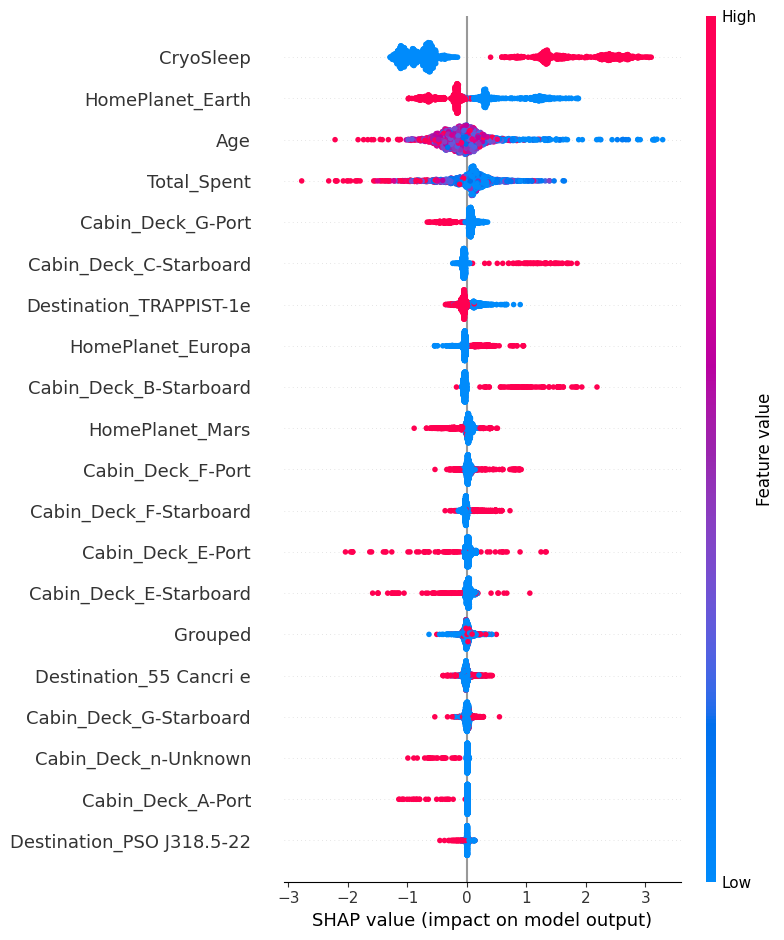

In [ ]:
import shap


explainer = shap.Explainer(model_xgb)
shap_values = explainer.shap_values(X_val_full)
shap.summary_plot(shap_values, X_val_full)

### Trying another approach.